Enter the number of stocks in the portfolio:  5
Enter ticker symbol for stock 1:  UBER
Enter ticker symbol for stock 2:  GOOG
Enter ticker symbol for stock 3:  AMZN
Enter ticker symbol for stock 4:  NFLX
Enter ticker symbol for stock 5:  BLK
Enter start date (YYYY-MM-DD):  2022-01-01
Enter end date (YYYY-MM-DD):  2024-12-12


[*********************100%***********************]  5 of 5 completed


Ticker            AMZN          BLK        GOOG        NFLX       UBER
Date                                                                  
2022-01-03  170.404495   841.542480  144.555099  597.369995  43.950001
2022-01-04  167.522003   846.609741  143.899460  591.150024  44.419998
2022-01-05  164.356995   823.119141  137.160675  567.520020  43.240002
2022-01-06  163.253998   826.552612  137.058548  553.289978  42.029999
2022-01-07  162.554001   823.580505  136.513992  541.059998  41.509998
...                ...          ...         ...         ...        ...
2024-12-05  220.550003  1044.780029  174.112473  917.869995  65.230003
2024-12-06  227.029999  1042.869995  176.290009  934.739990  66.089996
2024-12-09  226.089996  1046.380005  177.100006  913.690002  65.739998
2024-12-10  225.039993  1057.069946  186.529999  913.349976  64.959999
2024-12-11  230.259995  1065.260010  196.710007  936.559998  61.180000

[740 rows x 5 columns]
Ticker          AMZN       BLK      GOOG      NFLX   

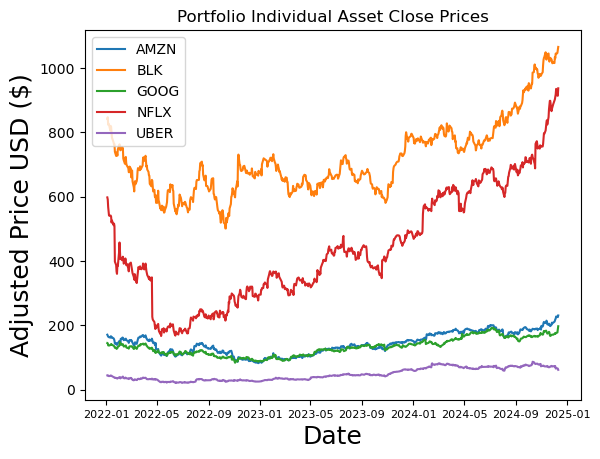

Ticker
AMZN    0.176678
BLK     0.116479
GOOG    0.158979
NFLX    0.282013
UBER    0.230723
dtype: float64
Ticker      AMZN       BLK      GOOG      NFLX      UBER
Ticker                                                  
AMZN    0.148191  0.055042  0.082291  0.095883  0.092398
BLK     0.055042  0.072756  0.043837  0.054034  0.057830
GOOG    0.082291  0.043837  0.107861  0.068450  0.062441
NFLX    0.095883  0.054034  0.068450  0.243886  0.097869
UBER    0.092398  0.057830  0.062441  0.097869  0.238400
[0.38495632 0.26973363 0.32842135 0.49384782 0.48826254]
0.09811878244140011
0.3132391776923827
52.58008898818315
Optimal Weights for Maximum Sharpe Ratio:
UBER: 0.00%
GOOG: 16.46%
AMZN: 29.30%
NFLX: 34.61%
BLK: 19.63%


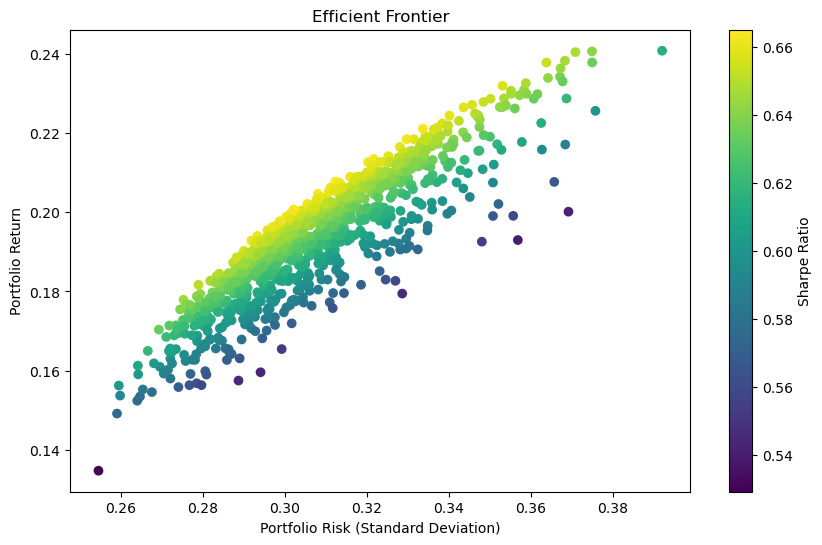

Enter the initial portfolio value:  10000
Enter the number of Monte Carlo simulations:  50
Enter the number of days to simulate:  100


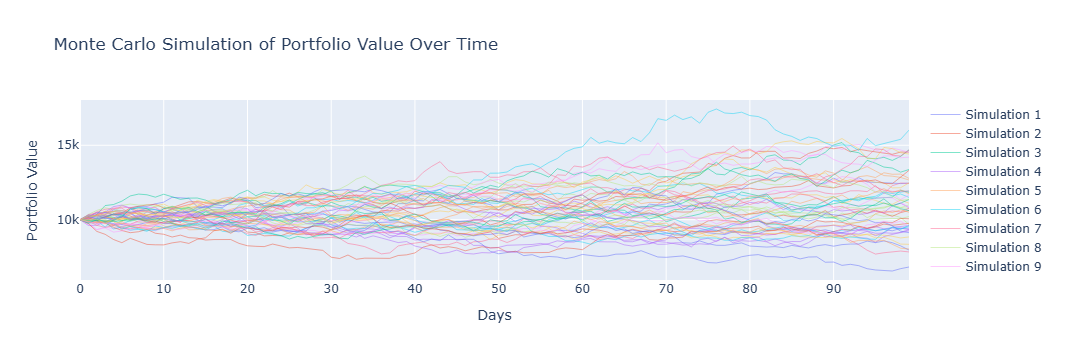

Ending Mean Value: $11104.18
Ending Standard Deviation: $2055.56
0th Percentile: $6820.89
10th Percentile: $8791.21
20th Percentile: $9411.56
30th Percentile: $9668.38
40th Percentile: $10566.93
50th Percentile: $10823.68
60th Percentile: $11418.68
70th Percentile: $11923.94
80th Percentile: $12685.89
90th Percentile: $14421.59
100th Percentile: $16019.22


In [16]:
# Import the neccessary libraries neccessary for our analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
import plotly.graph_objects as go

# Create a function that will store the financial data of specific stocks for a span of time
def get_stock_data(tickers, start_date, end_date):
    """Fetch historical data for a list of stocks."""
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

# Create a function that will compute the expected annual return of each stock by scaling the average percent change in close prices to the 252 open
# trading days in a year in the US stock market, along with the covariance matrix and volatilities of the selected stocks from the data in the
# selected time frame of analysis
def calculate_annualized_metrics(returns):
    """Calculate annualized return, variance, and volatility."""
    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252
    volatilities = np.sqrt(np.diag(cov_matrix))
    return mean_returns, cov_matrix, volatilities

# Create a function that will compute the expected return and expected risk of the portfolio 
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculate portfolio return and risk."""
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_risk

# Create a function that modifies equal weights at the start to the weight of each stock that would lead to the maximum Sharpe Ratio using the
# Sequential Least Squares Programming method where weights must sum to 1
def optimize_portfolio(mean_returns, cov_matrix):
    """Find optimal portfolio weights for maximum Sharpe Ratio."""
    num_assets = len(mean_returns)
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1.0 / num_assets]

    def neg_sharpe_ratio(weights):
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        return -portfolio_return / portfolio_risk

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    result = minimize(neg_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Create a function that will plot the efficient frontier of our portfolio so we can evaluate risk vs return payoffs, and observe which combinations
# generate better or worse Sharpe Ratios. Sharpe Ratios indicate the level or return associated with a risk where 1 is "normal", the greater the
# Sharpe Ratio the more rewarding the investment is for the risk associated with it
def plot_efficient_frontier(mean_returns, cov_matrix):
    """Generate the efficient frontier."""
    results = []
    num_assets = len(mean_returns)
    for _ in range(1000):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_return, portfolio_risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results.append((portfolio_return, portfolio_risk))
    results = np.array(results)
    plt.figure(figsize=(10, 6))
    plt.scatter(results[:, 1], results[:, 0], c=results[:, 0] / results[:, 1], cmap='viridis', marker='o')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Portfolio Return')
    plt.title('Efficient Frontier')
    plt.show()

# Create functions that will plot Monte Carlo simulations of the optimal portfolio based on optimal weights based on the initial portfolio amount
# input by the user, the number of simulations, and the number of days simulating over - while returning the mean, standard deviation, and
# every 10th percentile price value for the simulated data
def monte_carlo_portfolio_simulation(data, optimal_weights, initial_value, num_simulations, num_days):
    """Run Monte Carlo simulations for portfolio performance over time."""
    daily_returns = data.pct_change().dropna()
    mean_returns = daily_returns.mean()
    cov_matrix = daily_returns.cov()
    
    simulations = np.zeros((num_simulations, num_days))
    simulations[:, 0] = initial_value
    
    for sim in range(num_simulations):
        for day in range(1, num_days):
            daily_return = np.random.multivariate_normal(mean_returns, cov_matrix)
            portfolio_daily_return = np.sum(optimal_weights * daily_return)
            simulations[sim, day] = simulations[sim, day-1] * (1 + portfolio_daily_return)
    
    return simulations

def plot_monte_carlo_simulations(simulations, num_days):
    """Plot Monte Carlo simulations with interactive hover."""
    fig = go.Figure()
    
    for i in range(simulations.shape[0]):
        fig.add_trace(go.Scatter(
            y=simulations[i],
            x=list(range(num_days)),
            mode='lines',
            name=f'Simulation {i+1}',
            hoverinfo='x+y',
            line=dict(width=1),
            opacity=0.5
        ))
    
    fig.update_layout(
        title='Monte Carlo Simulation of Portfolio Value Over Time',
        xaxis_title='Days',
        yaxis_title='Portfolio Value',
        hovermode='closest'
    )
    
    fig.show()

def main():
    # User inputs
    num_stocks = int(input("Enter the number of stocks in the portfolio: "))
    tickers = [input(f"Enter ticker symbol for stock {i+1}: ") for i in range(num_stocks)]
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")

    # Fetch stock data
    data = get_stock_data(tickers, start_date, end_date)
    daily_returns = data.pct_change().dropna()
    print(data)
    print(daily_returns)

    # Visualize stock prices over time window
    title = 'Portfolio Individual Asset Close Prices'
    my_stocks = data
    for c in my_stocks.columns.values:
        plt.plot(my_stocks[c], label = c)
    plt.title(title)
    plt.xlabel('Date', fontsize = 18)
    plt.ylabel('Adjusted Price USD ($)', fontsize = 18)
    plt.xticks(fontsize = 8)
    plt.legend(my_stocks.columns.values, loc = 'upper left')
    plt.show()
    plt.ymin = 0

    # Calculate portfolio metrics
    mean_returns, cov_matrix, volatilities = calculate_annualized_metrics(daily_returns)
    print(mean_returns)
    print(cov_matrix)
    print(volatilities)
    optimal_weights = optimize_portfolio(mean_returns, cov_matrix)
    
    portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    print(portfolio_variance)
    print(portfolio_volatility)
    expected_portfolio_return = np.sum(mean_returns*optimal_weights*252)
    print(expected_portfolio_return)

    # Display results
    print("Optimal Weights for Maximum Sharpe Ratio:")
    for ticker, weight in zip(tickers, optimal_weights):
        print(f"{ticker}: {weight:.2%}")
    
    # Efficient Frontier
    plot_efficient_frontier(mean_returns, cov_matrix)

    initial_value = float(input("Enter the initial portfolio value: "))
    num_simulations = int(input("Enter the number of Monte Carlo simulations: "))
    num_days = int(input("Enter the number of days to simulate: "))
    
    simulations = monte_carlo_portfolio_simulation(data, optimal_weights, initial_value, num_simulations, num_days)
    plot_monte_carlo_simulations(simulations, num_days)
    ending_values = simulations[:, -1]
    ending_mean = np.mean(ending_values)
    ending_std = np.std(ending_values)

    print(f"Ending Mean Value: ${ending_mean:.2f}")
    print(f"Ending Standard Deviation: ${ending_std:.2f}")

    # Calculate and display prices at every 10th percentile
    percentiles = np.percentile(ending_values, range(0, 101, 10))
    for i, percentile in enumerate(percentiles):
        print(f"{i*10}th Percentile: ${percentile:.2f}")

if __name__ == "__main__":
    main()